# Cluster

Taking our clean df from 1_wrangle, checking assumptions, figuring out how many clusters to extract, and clustering on dietary patterns.


## Housekeeping

In [1]:
# If in colab, mount drive and set wd
# If local, set wd to parent of notebook
import os
import re

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ds1_nhanes/')
except:
  from pathlib import Path
  if not re.search(r'ds1_nhanes$', str(os.getcwd())):
    os.chdir(Path(os.getcwd()).parent)

print(os.getcwd())

c:\Users\cdonov12\local\repos\ds1_nhanes


Pull in dataset and keep only relevant columns

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read in the cleaned dietary recall data matched with FPED
nhanes = pd.read_csv('data/clean/nhanes_2017_2023_clean.csv', usecols = [0] + [1] + list(range(3, 40)))

# Remove columns with 'total' in name, also meat (includes other meat vars)
# I think this covers all the obviously collinear variables?
nhanes = nhanes.loc[:, ~nhanes.columns.str.contains('total|meat', case=False)]

# Pull out just food groups
foodgroups = nhanes.iloc[:, 2:]
print(foodgroups.columns)
print(foodgroups.shape)

# break out the identifier and features
id = nhanes.iloc[:,0]


Index(['f_citmlb_(cup_eq)', 'f_other_(cup_eq)', 'f_juice_(cup_eq)',
       'v_drkgr_(cup_eq)', 'v_redor_tomato_(cup_eq)', 'v_redor_other_(cup_eq)',
       'v_starchy_potato_(cup_eq)', 'v_starchy_other_(cup_eq)',
       'v_other_(cup_eq)', 'v_legumes_(cup_eq)', 'g_whole_(oz_eq)',
       'g_refined_(oz_eq)', 'pf_organ_(oz_eq)', 'pf_poult_(oz_eq)',
       'pf_seafd_hi_(oz_eq)', 'pf_seafd_low_(oz_eq)', 'pf_eggs_(oz_eq)',
       'pf_soy_(oz_eq)', 'pf_nutsds_(oz_eq)', 'pf_legumes_(oz_eq)',
       'd_milk_(cup_eq)', 'd_yogurt_(cup_eq)', 'd_cheese_(cup_eq)',
       'oils_(grams)', 'solid_fats_(grams)', 'add_sugars_(tsp_eq)',
       'a_drinks_(no._of_drinks)'],
      dtype='object')
(19386, 27)


## K-Means Clustering

[When working with distance-based algorithms, like k-Means Clustering, we must normalize the data. If we do not normalize the data, variables with different scaling will be weighted differently in the distance formula that is being optimized during training. The different FPED categories have different units, cup vs. oz, and each food may have a different range of total weight consumed.

StandardScaler is commonly used for standardization:]

### Preprocessing

Removing all totals, meat (subtotal), and v_legumes for now, just to see if it helps.

In [3]:
# Reduce to food groups, but WITHOUT v_legumes, or totals, or meat
pattern = '|'.join(['total', 'meat', 'v_legumes', 'SEQN', 'weight', 'drinks'])
# pattern = '|'.join(['total', 'meat', 'v_legumes', 'SEQN', 'weight', 'solid', 'sugar', 'drinks', 'oil'])
foodgroups = nhanes.loc[:, ~nhanes.columns.str.contains(pattern)]
print(foodgroups.shape)
print(foodgroups.columns)

(19386, 25)
Index(['f_citmlb_(cup_eq)', 'f_other_(cup_eq)', 'f_juice_(cup_eq)',
       'v_drkgr_(cup_eq)', 'v_redor_tomato_(cup_eq)', 'v_redor_other_(cup_eq)',
       'v_starchy_potato_(cup_eq)', 'v_starchy_other_(cup_eq)',
       'v_other_(cup_eq)', 'g_whole_(oz_eq)', 'g_refined_(oz_eq)',
       'pf_organ_(oz_eq)', 'pf_poult_(oz_eq)', 'pf_seafd_hi_(oz_eq)',
       'pf_seafd_low_(oz_eq)', 'pf_eggs_(oz_eq)', 'pf_soy_(oz_eq)',
       'pf_nutsds_(oz_eq)', 'pf_legumes_(oz_eq)', 'd_milk_(cup_eq)',
       'd_yogurt_(cup_eq)', 'd_cheese_(cup_eq)', 'oils_(grams)',
       'solid_fats_(grams)', 'add_sugars_(tsp_eq)'],
      dtype='object')


In [4]:
# import sci-kit for standardscaler
from sklearn.preprocessing import StandardScaler

# initialize the StandardScaler
scaler = StandardScaler()

# apply StandardScaler to the
foodgroups_scaled = scaler.fit_transform(foodgroups)

In [5]:
from sklearn.decomposition import PCA
pca = PCA()
foodgroups_pca = pca.fit_transform(foodgroups_scaled)

### Test Run

In [6]:
# import sci-kit for k means clustering
from sklearn.cluster import KMeans

# apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(foodgroups_pca, sample_weight=nhanes['weight_2d'])

Check out a plot with this test run:

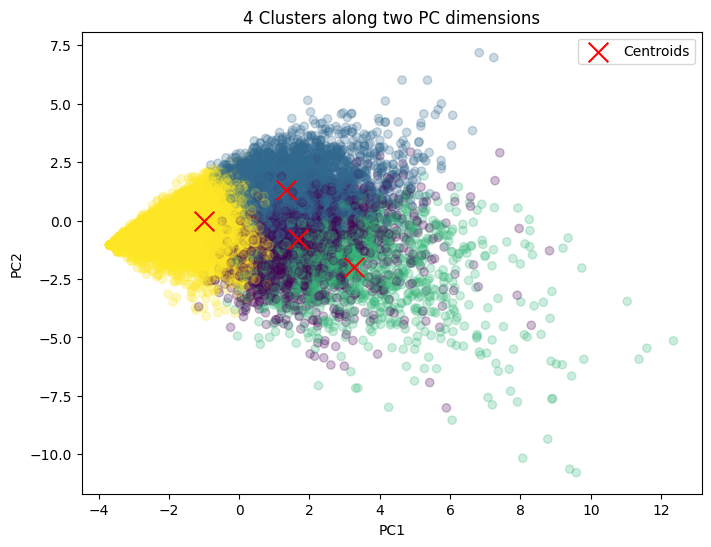

In [7]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    foodgroups_pca[:, 0],
    foodgroups_pca[:, 1],
    c=clusters,
    cmap='viridis',
    alpha=0.25
)
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    marker='x',
    s=200,
    label='Centroids'
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("4 Clusters along two PC dimensions")
plt.legend()

# Save it
plt.savefig('outputs/checkin_2/k4_cluster.png')

plt.show()

Check it out with a 3d plot from plotly. Note that we are importing this from our very own ds1_nhanes package. See ds1_nhanes/ds1_nhanes/utils.py to see or edit the code.

In [8]:
from ds1_nhanes.utils import graph_plotly
graph_plotly(df = foodgroups_pca, labels = clusters, title = '4 K-Means Clusters over 3 PC Dimensions')

### Determine optimal number of clusters

[We do not know how many clusters we should be using, the Silhoette Score and Elbow Method is commonly used to find the optimal number of clusters to ensure we are not overfitting with too many clusters or underfitting with too few.

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

The elbow method measures how tightly points cluster around centroids using sum of squared distances (SSD), the elbow is where the SSD stops decreasing sharply.]

In [9]:
from sklearn.metrics import silhouette_score
from matplotlib.ticker import FuncFormatter

K = range(2, 7)
fits = []
elbow_score = []
silhouette_scores = []

for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(foodgroups_pca, sample_weight=nhanes['weight_2d'])

    # append the model to fits
    fits.append(model)

    # Append the silhouette score to scores
    silhouette_scores.append(silhouette_score(foodgroups_pca, model.labels_, metric='euclidean'))

    # Store inertia (sum of squared distances)
    elbow_score.append(model.inertia_)

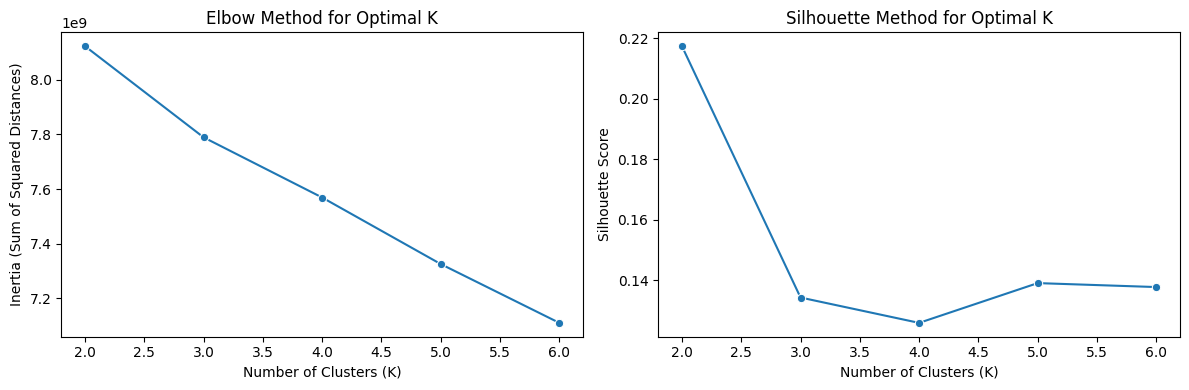

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Left plot: Elbow Method
sns.lineplot(x=K, y=elbow_score, marker="o", ax=axs[0])
axs[0].set_xlabel("Number of Clusters (K)")
axs[0].set_ylabel("Inertia (Sum of Squared Distances)")
axs[0].set_title("Elbow Method for Optimal K")

# Right plot: Silhouette Method (just an example — replace with correct data!)
sns.lineplot(x=K, y=silhouette_scores, marker="o", ax = axs[1])
axs[1].set_xlabel("Number of Clusters (K)")
axs[1].set_ylabel("Silhouette Score")
axs[1].set_title("Silhouette Method for Optimal K")

plt.tight_layout()
plt.savefig('outputs/checkin_2/elbow_silhouette.png', dpi=300)
plt.show()



Check out plots for a series of these:

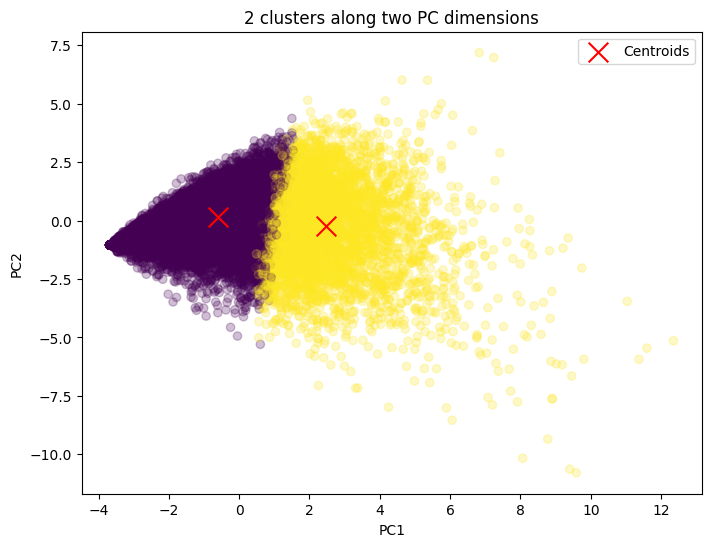

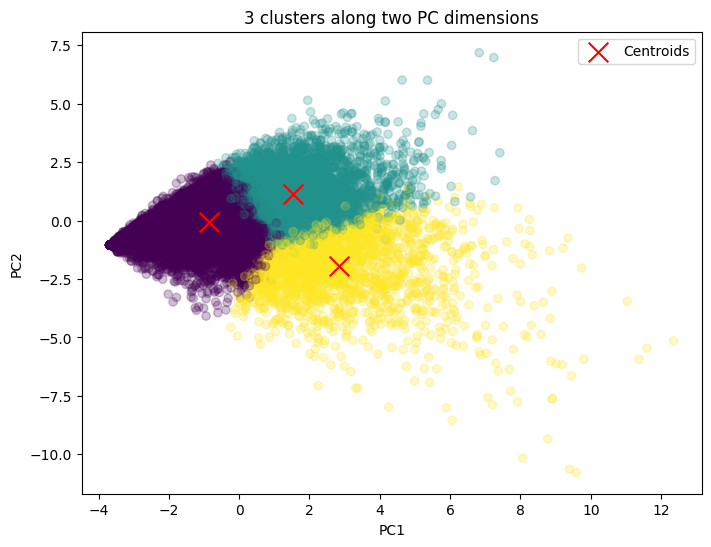

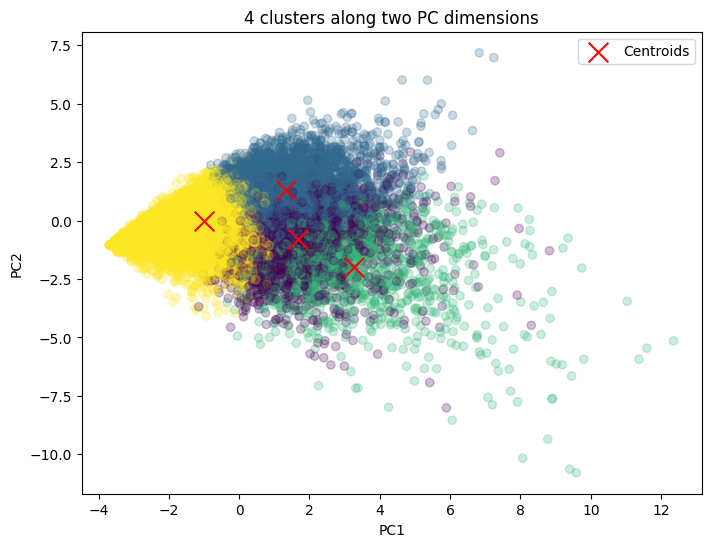

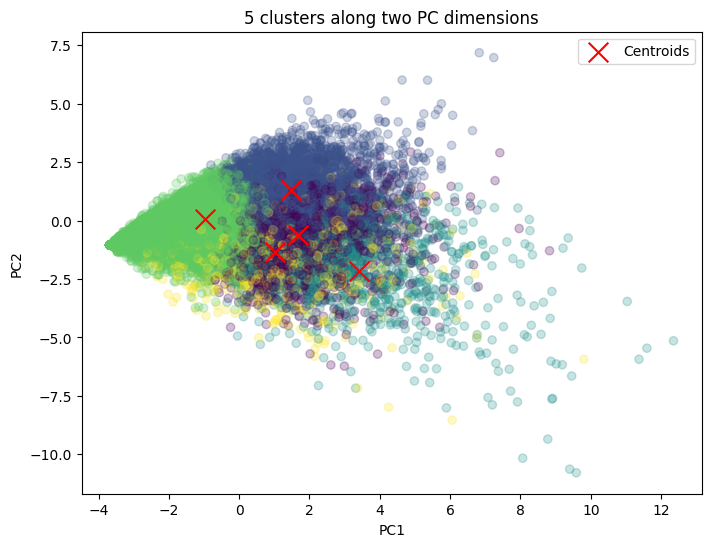

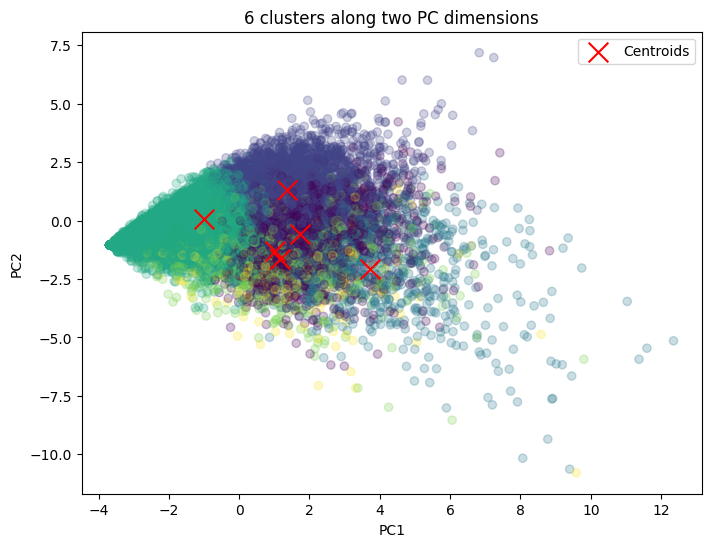

In [11]:
for fit in fits:
    clusters = fit.fit_predict(foodgroups_pca, sample_weight=nhanes['weight_2d'])

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        foodgroups_pca[:, 0],
        foodgroups_pca[:, 1],
        c=clusters,
        cmap='viridis',
        alpha=0.25
    )
    centers = fit.cluster_centers_
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        c='red',
        marker='x',
        s=200,
        label='Centroids'
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{fit.n_clusters} clusters along two PC dimensions")
    plt.legend()
    plt.show()

### Split Half Reliability

In [12]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import NearestNeighbors
# from sklearn.metrics import adjusted_rand_score

# def split_half_val(df, k=3, random_state=None):
#     # Split data in half
#     train, test = train_test_split(df, test_size=0.5, random_state=random_state)

#     # Cluster training half
#     km_train = KMeans(n_clusters=k, random_state=random_state).fit(train)
#     train_labels = km_train.labels_

#     # NN to pair each training point with a test point
#     nn = NearestNeighbors(n_neighbors=1).fit(train)
#     distances, indices = nn.kneighbors(test)
#     nn_labels = train_labels[indices.flatten()]

#     # Cluster test set
#     km_test = KMeans(n_clusters=k, random_state=random_state).fit(test)
#     test_labels = km_test.labels_

#     # Get Adjusted Rand Scores that compare test labels to nn labels
#     ari = adjusted_rand_score(test_labels, nn_labels)
#     return ari

# # Second function just makes iterations easier
# def iterate_val(df, k=3, n_iter=10, random_state=42):
#     aris = []
#     for i in range(n_iter):
#         ari = split_half_val(df, k=k, random_state=random_state + i)
#         aris.append(ari)
#     return aris

In [14]:
# Loading functions from ds1_nhanes utilities
from ds1_nhanes.utils import split_half_val, iterate_val

aris = iterate_val(foodgroups_pca, k=3, n_iter=10, random_state=42)
print(aris)
print(f"Mean ARI: {round(np.mean(aris), 3)}")

[0.48786575077968414, 0.537124160923365, 0.5197230405403056, 0.5425277764921239, 0.5207584686002987, 0.540980236528954, 0.546732579653788, 0.5371711303186231, 0.5593399569704717, 0.5331438195724484]
Mean ARI: 0.533


## Backup Plans

### Consolidate Food Groups

Testing if reducing FPED groups into categories by summing each group into one column helps at all. In hindsight, I should have just used the totals columns instead of removing them and then doing this manually. Smort

In [15]:
nhanes.columns

Index(['SEQN', 'weight_2d', 'f_citmlb_(cup_eq)', 'f_other_(cup_eq)',
       'f_juice_(cup_eq)', 'v_drkgr_(cup_eq)', 'v_redor_tomato_(cup_eq)',
       'v_redor_other_(cup_eq)', 'v_starchy_potato_(cup_eq)',
       'v_starchy_other_(cup_eq)', 'v_other_(cup_eq)', 'v_legumes_(cup_eq)',
       'g_whole_(oz_eq)', 'g_refined_(oz_eq)', 'pf_organ_(oz_eq)',
       'pf_poult_(oz_eq)', 'pf_seafd_hi_(oz_eq)', 'pf_seafd_low_(oz_eq)',
       'pf_eggs_(oz_eq)', 'pf_soy_(oz_eq)', 'pf_nutsds_(oz_eq)',
       'pf_legumes_(oz_eq)', 'd_milk_(cup_eq)', 'd_yogurt_(cup_eq)',
       'd_cheese_(cup_eq)', 'oils_(grams)', 'solid_fats_(grams)',
       'add_sugars_(tsp_eq)', 'a_drinks_(no._of_drinks)'],
      dtype='object')

In [16]:
df = pd.DataFrame()
df['fruit'] = nhanes.loc[:, nhanes.columns.str.contains('^f_')].sum(axis=1)
df['veg'] = nhanes.loc[:, nhanes.columns.str.contains('^v_')].sum(axis=1)
df['grain'] = nhanes.loc[:, nhanes.columns.str.contains('^g_')].sum(axis=1)
df['pf'] = nhanes.loc[:, nhanes.columns.str.contains('^pf_')].sum(axis=1)
df['dairy'] = nhanes.loc[:, nhanes.columns.str.contains('^d_')].sum(axis=1)
df['oil'] = nhanes.loc[:, nhanes.columns.str.contains('oils')]
df['fat'] = nhanes.loc[:, nhanes.columns.str.contains('solid')]
df['sugar'] = nhanes['add_sugars_(tsp_eq)']
# df['alcohol'] = nhanes['a_drinks_(no._of_drinks)']
df['weight_2d'] = nhanes['weight_2d']
df.head()

fruit   veg  grain    pf  dairy     oil     fat  sugar  weight_2d
0   1.60  0.36  15.99  4.24   3.45   25.41   82.28  49.04    8904.03
1   0.00  4.17  19.85  7.22   3.21  119.77  107.89  43.70    3626.88
2   2.28  3.34  10.72  5.86   3.78  104.86  168.54  45.45   17806.00
3   0.87  4.09  11.15  3.05   2.90   82.41   40.39  14.80    2994.10
4   0.04  1.85  13.39  2.41   3.24  175.65   87.97  18.82    9115.96

Let's check correlations again before we pre-process

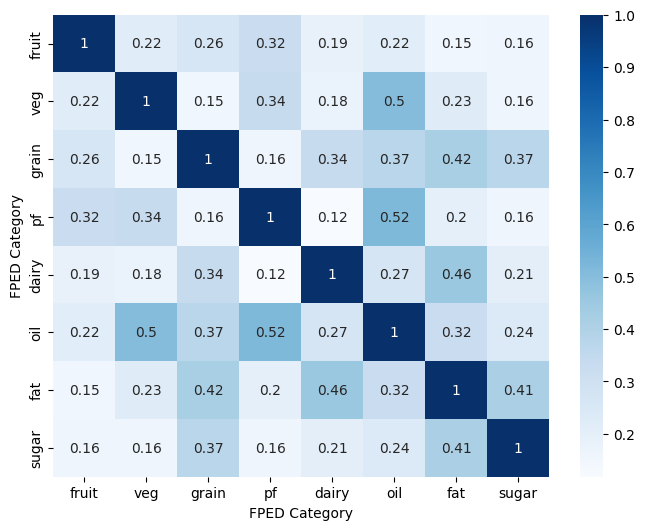

In [17]:
cor_dat = df.copy().drop(columns=['weight_2d'])
matrix = cor_dat.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    matrix,
    cmap='Blues',
    annot=True
  )
plt.xlabel('FPED Category')
plt.ylabel('FPED Category')
plt.show()

Now pre-process and cluster:

In [18]:
df_scaled = StandardScaler().fit_transform(df)
df_pca = PCA().fit_transform(df_scaled)
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(df_pca, sample_weight=nhanes['weight_2d'])

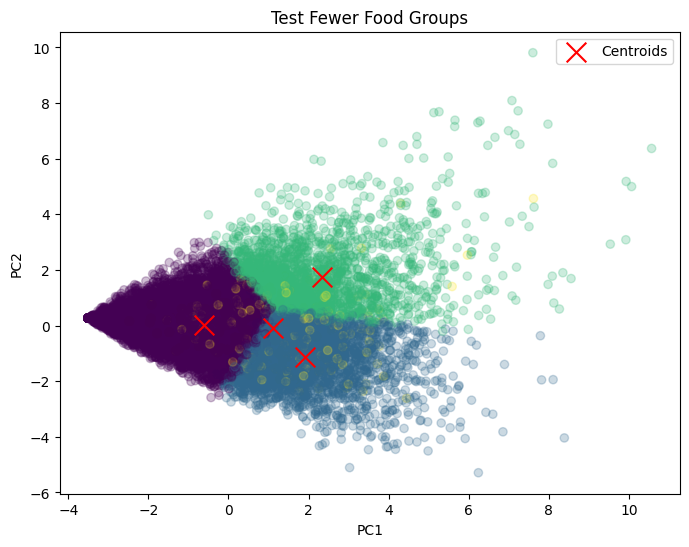

In [19]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_pca[:, 0],
    df_pca[:, 1],
    c=labels,
    cmap='viridis',
    alpha=0.25
)
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    marker='x',
    s=200,
    label='Centroids'
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Test Fewer Food Groups")
plt.legend()
plt.show()

In [20]:
graph_plotly(df=df_pca, labels=labels, title='K-Means Clusters on Consolidated Food Groups')

This is not half bad?

Try plotting more ks:

In [21]:
K = range(2, 7)
fits = []
elbow_score = []
silhouette_scores = []

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(df_pca, sample_weight=nhanes['weight_2d'])
    fits.append(model)
    # silhouette_scores.append(silhouette_score(df_pca, model.labels_, metric='euclidean'))
    # elbow_score.append(model.inertia_)

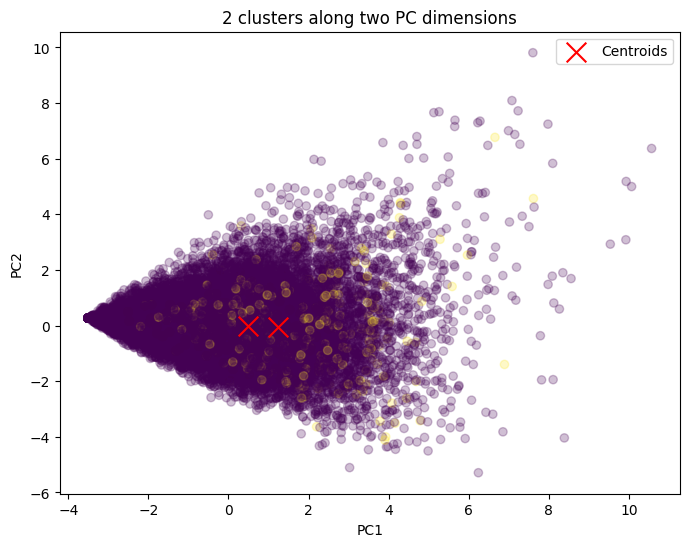

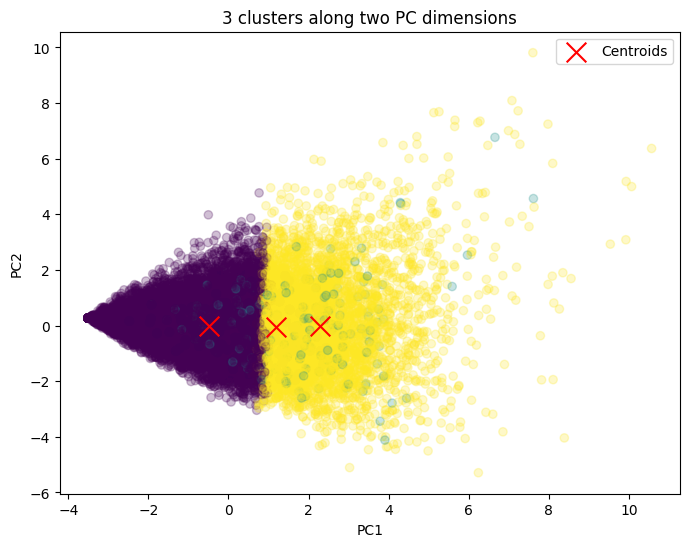

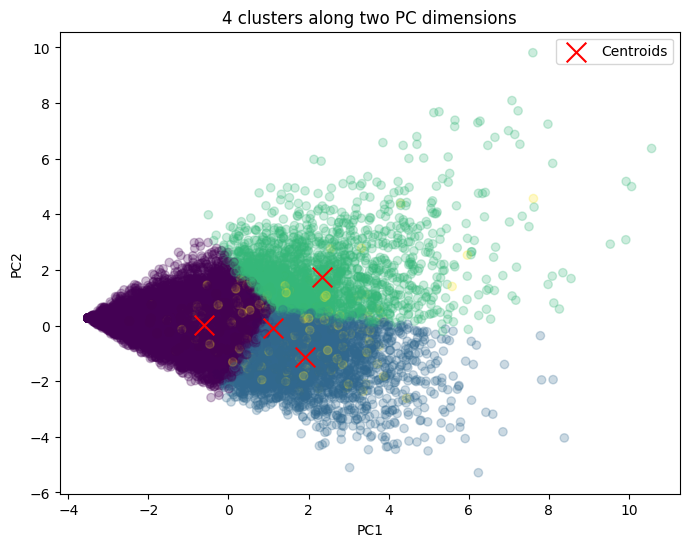

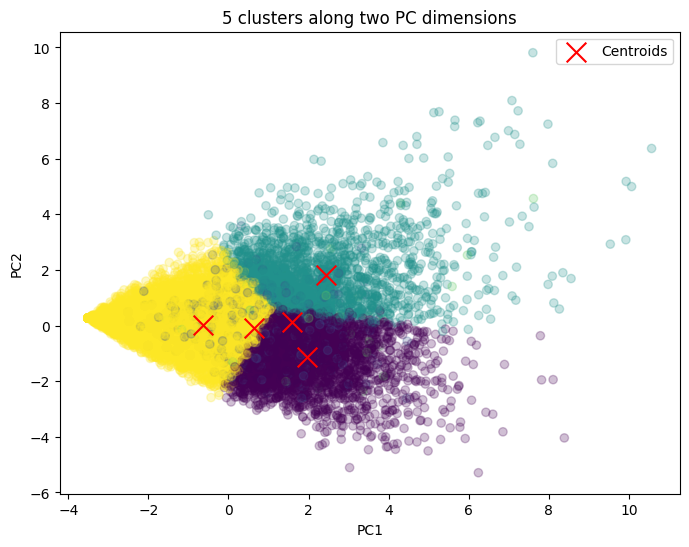

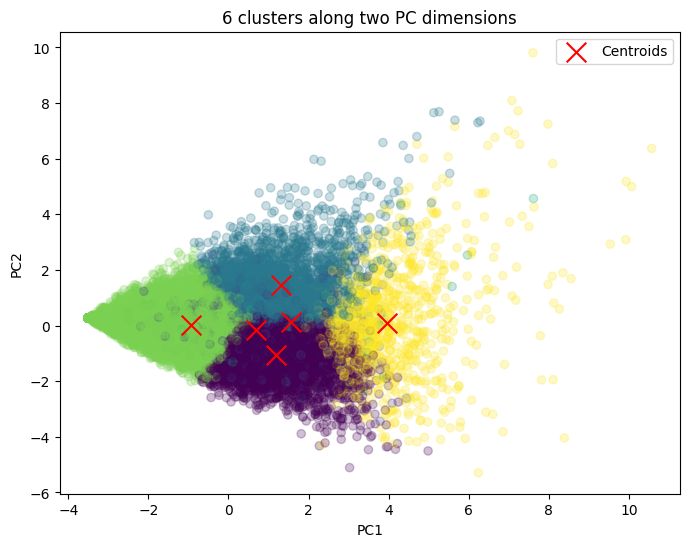

In [22]:
for fit in fits:
    clusters = fit.fit_predict(df_pca, sample_weight=nhanes['weight_2d'])

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        df_pca[:, 0],
        df_pca[:, 1],
        c=clusters,
        cmap='viridis',
        alpha=0.25
    )
    centers = fit.cluster_centers_
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        c='red',
        marker='x',
        s=200,
        label='Centroids'
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{fit.n_clusters} clusters along two PC dimensions")
    plt.legend()
    plt.show()

### Spectral Cluster

Something is clearly afoot here. For starters, running it on the foodgroups_pca data didn't finish after 10 minutes or so, so I gave up on it. The two runs below are with the reduced df_pca data, aggregated by food group. I ran it assigning labels with kmeans and also with discretize, which should be more robust to initialization. But there is obviously something wrong here. We could try messing around with gamma, affinity, n neighbors, eigen_tol, etc.

In [29]:
from sklearn.cluster import SpectralClustering
spectral_cluster = SpectralClustering(
    n_clusters=3,
    assign_labels='kmeans',
    random_state=42
).fit(df_pca)

In [30]:
from ds1_nhanes.utils import graph_plotly
graph_plotly(df = df_pca, labels = spectral_cluster.labels_, title = 'Spectral Clusters')

Okay this does not look ideal. Let's try discretize

In [31]:
from sklearn.cluster import SpectralClustering
spectral_cluster = SpectralClustering(
    n_clusters=3,
    assign_labels='discretize',
    random_state=42
).fit(df_pca)

In [32]:
from ds1_nhanes.utils import graph_plotly
graph_plotly(df = df_pca, labels = spectral_cluster.labels_, title = 'Spectral Clusters')

### Gaussian Mixture

Trying Gaussian mixture with 2 through 6 components

In [24]:
from sklearn.mixture import GaussianMixture

gm_fits = []
gm_labels = []

for i in np.arange(2, 7):
    fit = GaussianMixture(n_components=i, random_state=42).fit(foodgroups_pca)
    label = fit.predict(foodgroups_pca)
    gm_fits.append(fit)
    gm_labels.append(label)

Plot them

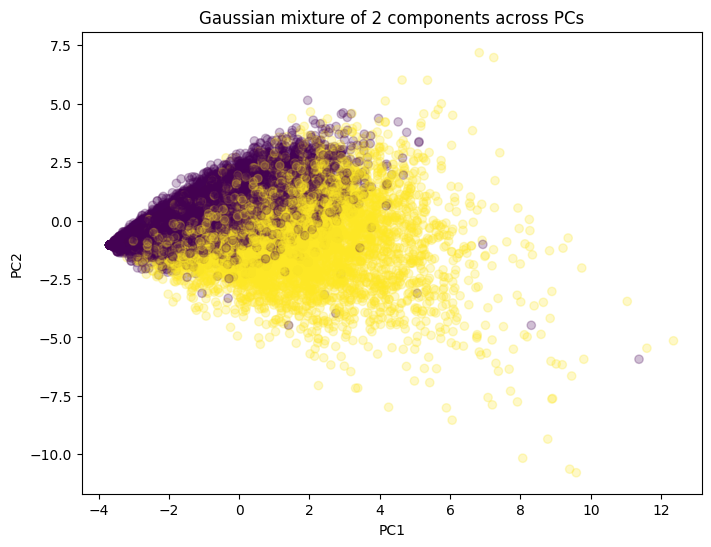

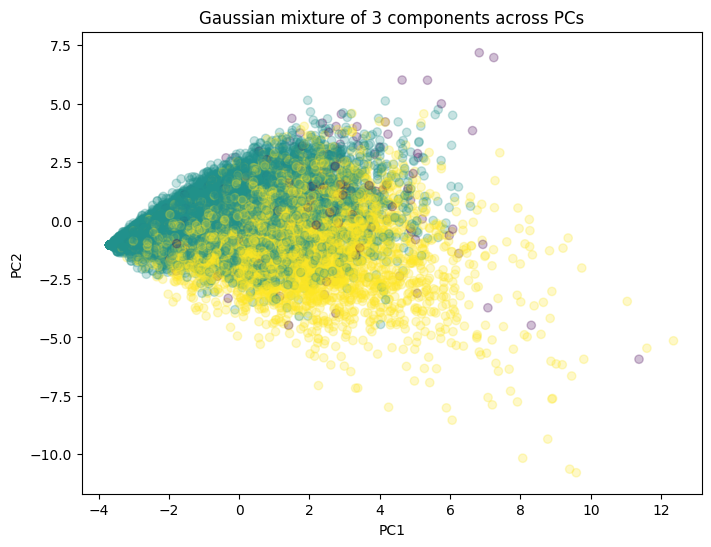

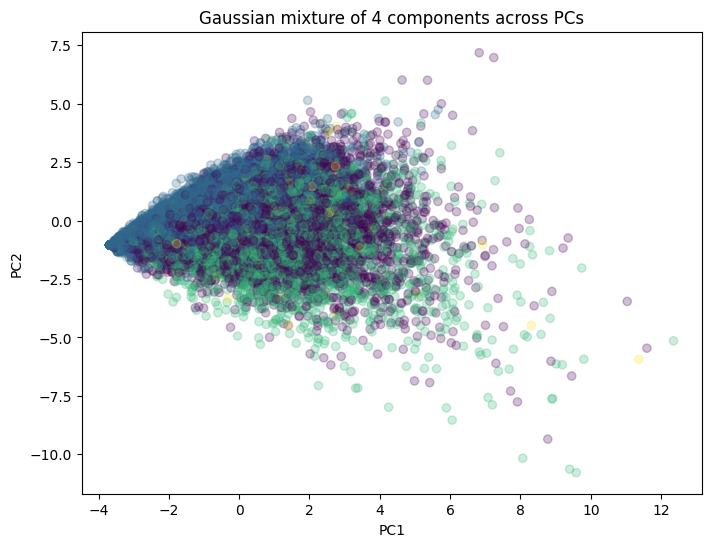

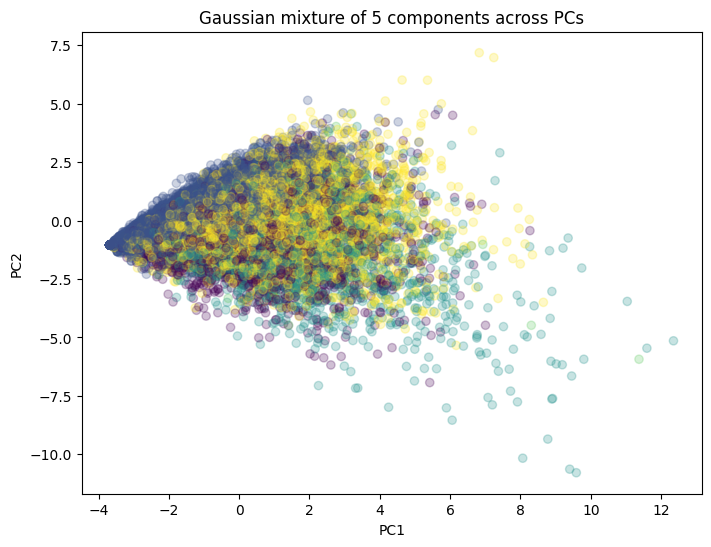

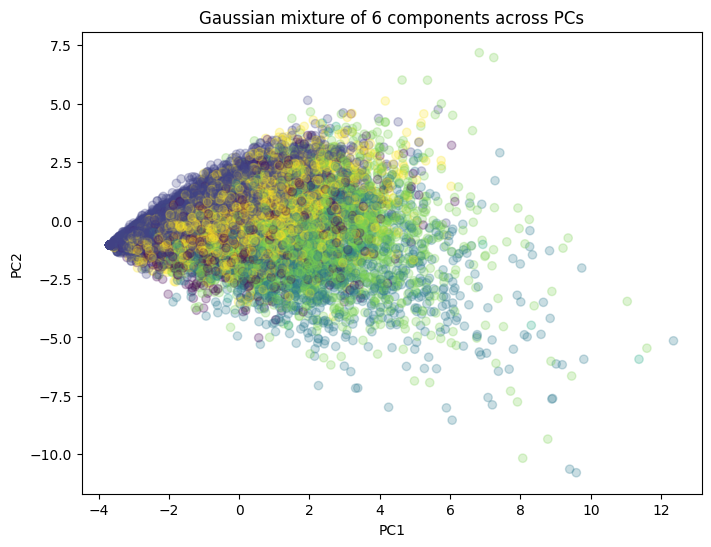

In [25]:
for i in np.arange(2, 7):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        foodgroups_pca[:, 0],
        foodgroups_pca[:, 1],
        c=gm_labels[i - 2],
        cmap='viridis',
        alpha=0.25
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Gaussian mixture of {i} components across PCs")
    plt.show()

In [26]:
# Try a 3d plot for one of these
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=foodgroups_pca[:, 0],
    y=foodgroups_pca[:, 1],
    z=foodgroups_pca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=gm_labels[1],
        colorscale='Viridis',
        opacity=0.5
    ),
    name="Data Points"
))

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Gaussian Mixture on PCA Dimensions'
)

fig.show()

Check AIC and BIC curves. Lower numbers are better in each case, only interpreted relative to other values.

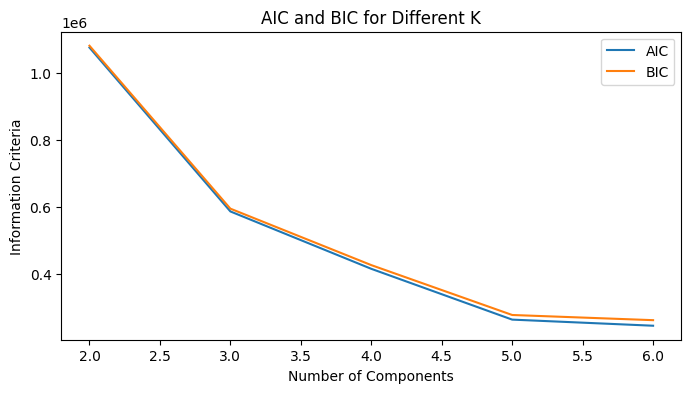

In [27]:
AIC = [fit.aic(foodgroups_pca) for fit in gm_fits]
BIC = [fit.bic(foodgroups_pca) for fit in gm_fits]

plt.figure(figsize=(8, 4))
plt.plot(np.arange(2, 7), AIC, label='AIC')
plt.plot(np.arange(2, 7), BIC, label='BIC')
plt.xlabel("Number of Components")
plt.ylabel("Information Criteria")
plt.title("AIC and BIC for Different K")
plt.legend()
plt.show()

### t-SNE

Try visualizing same plots with t-distributed Stoachastic Neighbor Embedding.

What does it do? "t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results."

In other words, I have no idea. But it is just a way to visualize clusters, not a clustering method in itself.

Note - this takes about 8 minutes to run, so I am commenting it out so we don't run it accidentally.

In [28]:
# from sklearn.manifold import TSNE

# KMeans
# kmeans = KMeans(n_clusters=3, random_state=42)
# labels = kmeans.fit_predict(foodgroups_pca)

# # fit TSNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
# foodgroups_tsne = tsne.fit_transform(foodgroups_pca)

# plt.figure(figsize=(8, 6))
# plt.scatter(
#     foodgroups_tsne[:, 0],
#     foodgroups_tsne[:, 1],
#     c=labels,
#     cmap='tab10',
#     alpha=0.5
# )
# plt.title("KMeans Clusters Visualized with t-SNE")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.show()